In [1]:
import numpy as np
#pip install pysindy
import pysindy as psd
from data_loader import data_loader_noH
import numpy as np
import matplotlib.pyplot as plt
from utils import params

In [2]:
x_train, dx_train, x_val, dx_val = data_loader_noH()

In [3]:
library = psd.PolynomialLibrary(degree=2)
model = psd.SINDy(optimizer=psd.STLSQ(threshold=0.001), feature_library=library)

In [4]:
model.fit(x_train, t = 1, x_dot=dx_train)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'],
      optimizer=STLSQ(threshold=0.001))

In [6]:
#model.print()

(x0)' = 0.078 1 + 0.005 x0 + 0.315 x1 + -0.216 x2 + -0.139 x3 + -0.013 x4 + -0.053 x5 + 0.046 x0^2 + -0.154 x0 x1 + 0.236 x0 x2 + -0.047 x0 x3 + -0.106 x0 x4 + 0.043 x1^2 + 0.058 x1 x2 + -0.118 x1 x3 + -0.032 x1 x4 + 0.118 x1 x5 + -0.099 x2^2 + -0.021 x2 x3 + 0.048 x2 x4 + -0.145 x2 x5 + 0.061 x3^2 + 0.049 x3 x4 + 0.050 x3 x5 + 0.030 x4^2 + 0.021 x4 x5 + -0.029 x5^2
(x1)' = 0.025 1 + 0.031 x0 + 0.509 x1 + -0.312 x2 + -0.069 x3 + 0.138 x4 + -0.362 x5 + 0.080 x0^2 + -0.218 x0 x1 + 0.306 x0 x2 + -0.038 x0 x3 + -0.158 x0 x4 + -0.022 x0 x5 + 0.080 x1^2 + 0.077 x1 x2 + -0.168 x1 x3 + 0.022 x1 x4 + 0.037 x1 x5 + -0.102 x2^2 + -0.111 x2 x3 + -0.024 x2 x4 + -0.064 x2 x5 + 0.136 x3^2 + 0.034 x3 x4 + 0.046 x3 x5 + -0.015 x4^2 + 0.154 x4 x5 + -0.049 x5^2
(x2)' = 0.076 1 + -0.047 x0 + 0.660 x1 + -0.322 x2 + -0.035 x3 + 0.043 x4 + -0.366 x5 + 0.080 x0^2 + -0.216 x0 x1 + 0.137 x0 x2 + 0.001 x0 x3 + -0.072 x0 x4 + 0.011 x0 x5 + 0.069 x1^2 + 0.018 x1 x2 + -0.066 x1 x3 + -0.067 x1 x4 + 0.076 x1 x5 + 0.0

In [7]:
theta = np.array(library.transform(x_val))
sindy_coeff = np.transpose(model.coefficients())
dx_predict = np.matmul(theta, sindy_coeff)

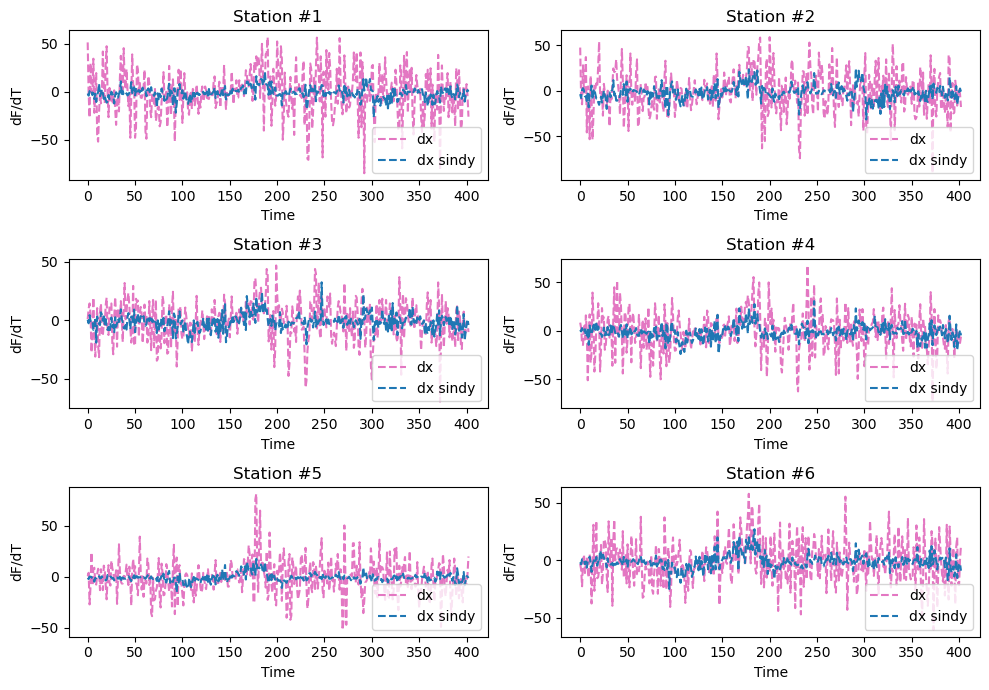

In [8]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))

# Plot each column in a separate subplot
for row in range(3):
    for col in range(2):
        #axs[row, col].plot(dx_ori[:, row*2 + col], label = 'dx')
        axs[row, col].plot(100*dx_val[:, row*2 + col], "--", color = '#e377c2', label = 'dx')
        axs[row, col].plot(100*dx_predict[:, row*2 + col], "--", color = '#1f77b4' ,label = 'dx sindy')
        axs[row, col].set_title(f'Station #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('dF/dT')
        axs[row, col].legend(loc='lower right', fontsize='medium')

# Show the figure
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/dz_dzSINDy_Plot.png", dpi=300)

In [24]:
from sindy_utils import sindy_library
sim_result_1 = np.zeros(x_val.shape)
sim_result_2 = np.zeros(x_val.shape)
sim_result_3 = np.zeros(x_val.shape)

In [25]:
for t in range(x_val.shape[0]):
    x_init = x_val[t,:].reshape(1,-1)
    Theta_curr = np.array(library.transform(x_init))
    dx_curr = np.matmul(Theta_curr, sindy_coeff)
    x_new = x_init + dx_curr
    sim_result_1[t,:] = x_new

In [26]:
# fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(9, 15))
# for i in range(6):
#     axs[i].plot(100*sim_result_1[:-1, i], label = '5mins Predicted')
#     axs[i].plot(100*x_val[1:,i], label = 'Original')
#     axs[i].legend()
# plt.tight_layout()
# plt.show()

In [27]:
np.save("Pred_Results/one_step_pred_sindy.npy", sim_result_1)
np.save("Pred_Results/x_val_sindy.npy", x_val)

In [28]:
from sklearn.metrics import mean_squared_error as mse

In [29]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_1[:-1, i], 100*x_val[1:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [30]:
import pandas as pd
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/Sindy.csv")
accuracy

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6
1,41.92,41.62,28.01,36.19,30.28,32.95


In [31]:
for t in range(sim_result_1.shape[0]):
    z_current = sim_result_1[t,:].reshape(1,-1)
    Theta_curr = sindy_library(z_current,2,False)
    dz_curr = np.matmul(Theta_curr, sindy_coeff)
    z_next = z_current + dz_curr
    sim_result_2[t,:] = z_next

In [32]:
# fig, axs = plt.subplots(nrows=params['partial_measurement'], ncols=1, figsize=(9, 15))
# for i in range(params['partial_measurement']):
#     axs[i].plot(100*sim_result_2[:-2, i], label = '10mins Predicted')
#     axs[i].plot(100*x_val[2:,i], label = 'Original')
#     axs[i].legend()
# plt.tight_layout()
# plt.show()

In [33]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100 * sim_result_2[:-2, i], 100 * x_val[2:, i]))
    rmse_i[f'Station #{i + 1}'] = rmse_curr

In [34]:
import pandas as pd
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindy_10mins.csv")
accuracy

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6
1,45.26,45.02,34.56,41.04,33.93,35.49


In [35]:
for t in range(sim_result_2.shape[0]):
    z_current = sim_result_2[t,:].reshape(1,-1)
    Theta_curr = sindy_library(z_current,2,False)
    dz_curr = np.matmul(Theta_curr, sindy_coeff)
    z_next = z_current + dz_curr
    sim_result_3[t,:] = z_next

In [36]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100 * sim_result_3[:-3, i], 100 * x_val[3:, i]))
    rmse_i[f'Station #{i + 1}'] = rmse_curr

In [37]:
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindy_15mins.csv")
accuracy

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6
1,50.11,50.78,40.13,46.2,36.63,38.54


In [45]:
import random
indices = range(6)
index_pair = []
for i in range(6):
    for j in range(i+1, 6):
        index_pair.append((indices[i], indices[j]))
random.seed(100)
index_pair = random.sample(index_pair, 6)

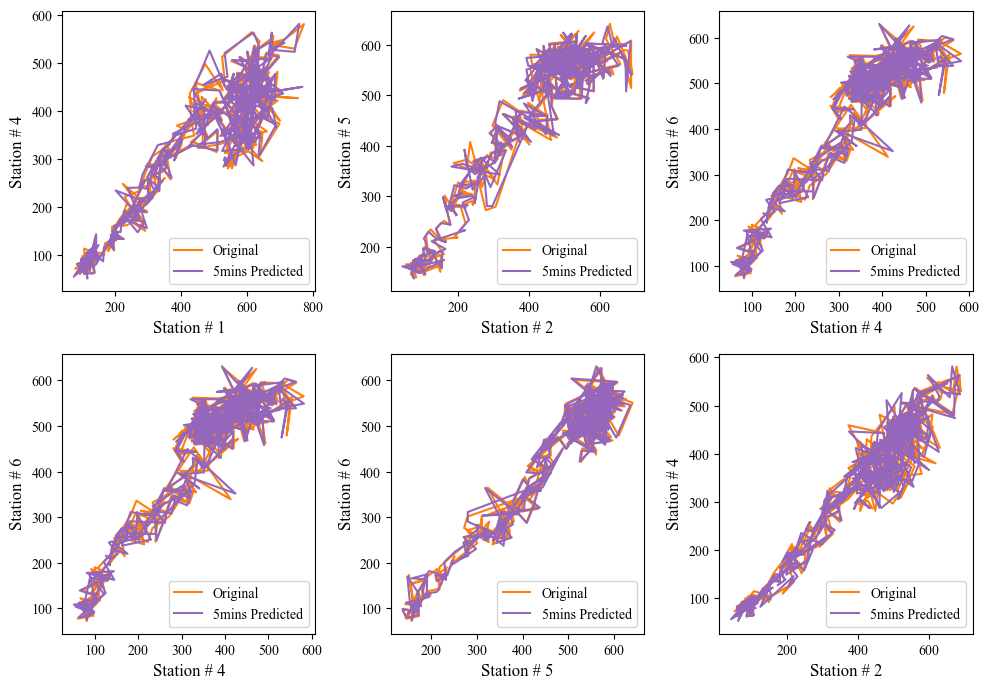

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
for row in range(2):
    for col in range(3):
        index1 = index_pair[row*2 + col][0]
        index2 = index_pair[row*2 + col][1]
        axs[row, col].plot(100 * x_val[:-1,index1], 100 * x_val[:-1,index2], color = '#ff7f0e', label = 'Original')
        axs[row, col].plot(100 * sim_result_1[1:,index1], 100 * sim_result_1[1:,index2], color = '#9467bd', label = '5mins Predicted')
        #axs[row, col].plot(100 * X_ori[1:,index1], 100 * X_ori[1:,index2], "--", label = '5mins Predicted')
        axs[row, col].legend(loc='lower right', fontsize='medium')
        axs[row, col].set_xlabel(f'Station # {index1 + 1}', fontsize = 12)
        axs[row, col].set_ylabel(f'Station # {index2 + 1}', fontsize = 12)
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/predicted_and_z_phase.png", dpi = 300)